In [1]:
import optuna
import os, warnings
from pathlib import Path
from glob import glob

import numpy as np 
import scipy as sp
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision


import flyr

In [ ]:
# changing all RGB cropped from .jpg to .png 
#from PIL import Image

#jpg_path = Path("/Users/ameliakeyser-gibson/Documents/SEFS/Kim Lab/vines grant/thermal/monthly images/training/annotated/non")

#for file in jpg_path.glob('*.jpg'):
    im = Image.open(file)
    png_file = str(file).replace(".jpg", ".png")
    im.save(png_file)

In [2]:
# Dataset loader class
class FlirDataset(torch.utils.data.Dataset):
    ""
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, k):
        return self.samples[k]
    def __init__(self, path, datatype='train', image_subsize=64, stride=None): 
        from glob import glob
        from pathlib import Path
        path = Path(path)
        if datatype == "train":
            tt = "train"
        elif datatype == "test":
            tt = "test"
        elif datatype == "validation":
            tt = "validation"
        elif datatype is None:
            tt = "non"
        else:
            raise ValueError("datatype must be 'train', 'test', 'validation', or None")
        annot_pattern = str(path / "training" / "annotated" / tt / "*.png")
        annot_filenames = glob(annot_pattern)
        annot_ims = {
            Path(filename).name[:-4]: plt.imread(filename)
            for filename in annot_filenames}
        flir_pattern = str(path / "*" / "thermal" / "*.jpg")
        flir_filenames = {
            Path(file).name[:-4]: file
            for file in glob(flir_pattern)}
        self.names = list(annot_ims.keys())
        flir_ims = {
            key: self.load_flir(flir_filenames[key])
            for key in self.names}
        self.images = flir_ims
        self.annots = annot_ims
        #for (file, ims, annot) in zip(list(self.names()), list(self.images()), list(self.annots())):
            #if ims[1].shape[:2] != annot.shape[:2]:
               # plt.imshow(annot)
                #print(file, ims[1].shape, annot.shape)
        imsz = image_subsize
        stride = imsz if stride is None else stride
        sdata = {}
        for key in self.names:
            (thr_im, opt_im) = self.images[key]
            ann_im = self.annots[key]
            for (rno, rowidx) in enumerate(range(0, opt_im.shape[0], stride)):
                if rowidx + imsz >= opt_im.shape[0]:
                    continue
                for (cno, colidx) in enumerate(range(0, opt_im.shape[1], stride)):
                    if colidx + imsz >= opt_im.shape[1]:
                        continue
                    # Get the subimage from the optical and annotation images:
                    opt_sub = opt_im[rowidx:rowidx + imsz, colidx:colidx + imsz]
                    thr_sub = thr_im[rowidx:rowidx + imsz, colidx:colidx + imsz]
                    ann_sub = ann_im[rowidx:rowidx + imsz, colidx:colidx + imsz]
                    tup = (rowidx, colidx, opt_sub, ann_sub, thr_sub)
                    sdata[key, rno, cno] = tup
        self.sample_data = sdata
        self.masks = {}
        self.image_subsize = image_subsize
        self.samples = []
        for ((k,rno,cno), tup) in sdata.items():
            (rowidx, colidx, opt_sub, ann_sub, thr_sub) = tup
            #plant_pixels = np.all(ann_sub[:,:,0:3] == [1, 0, 0], axis=2)
            plant_pixels = (ann_sub[:,:,0] - ann_sub[:,:,1] - ann_sub[:,:,2] > 0.9)
            self.masks[k, rno, cno] = plant_pixels
            opt_for_torch = torch.permute(
                torch.tensor(opt_sub, dtype=torch.float) / 255,
                (2, 0, 1))
            ann_frac = 1 - np.sum(plant_pixels) / plant_pixels.size
            #ann_frac = torch.tensor(
            #    round(ann_frac * 999),
            #    dtype=torch.long)
            ann_frac = torch.tensor(ann_frac, dtype=torch.float)
            #sample = (opt_for_torch, ann_frac)
            mask = torch.tensor(self.masks[k, rno, cno], dtype=torch.float32)
            sample = (opt_for_torch, mask[None,...])
            self.samples.append(sample)
    def load_flir(self, filename, thermal_unit='celsius'):
        """Loads and returns the portion of a FLIR image file that contains both
        optical and thermal data.
        
        Parameters
        ----------
        filename : pathlike
            A ``pathname.Path`` object or a string representing the filename of
            image that is to be loaded.
        thermal_unit : {'celsius' | 'kelvin' | 'fahrenheit'}, optional
            What temperature units to return; the default is ``'celsius'``.
            
        Returns
        -------
        optical_image : numpy.ndarray
            An image-array with shape ``(rows, cols, 3)`` containing the RGB
            optical of the visual FLIR image.
        thermal_image : numpy.ndarray
            An image-array with shape ``(rows, cols)`` containing the thermal
            values in Celsius.
        """
        from os import fspath
        from PIL import Image
        import flyr
        # Make sure we have a path:
        filename = fspath(filename)
        # Import the raw image data:
        flir_image = flyr.unpack(filename)
        # Extract the optical and thermal data:
        opt = flir_image.optical
        #plt.imshow(opt)
        thr = getattr(flir_image, thermal_unit)
        pip = flir_image.pip_info
        x0 = pip.offset_x
        y0 = pip.offset_y
        ratio = pip.real_to_ir
        ratio = opt.shape[0] / thr.shape[0] / ratio
        # Resize the thermal image to match the optical image in resolution:
        (opt_rs, opt_cs, _) = opt.shape
        (thr_rs, thr_cs) = np.round(np.array(thr.shape) * ratio).astype(int)
        thr = np.array(Image.fromarray(thr).resize([thr_cs, thr_rs]))
        #plt.imshow(thr)
        x0 = round(opt_cs // 2 - thr_cs // 2 + x0)
        y0 = round(opt_rs // 2 - thr_rs // 2 + y0)
        return (thr, opt[y0:y0+thr_rs, x0:x0+thr_cs, :])
    def pred_all(self, model):
        """Returns predicted segmentations for all items in the dataset."""
        shape = (self.image_subsize, self.image_subsize)
        inpts = torch.stack([img for (img,_) in self.samples if img.shape[1:] == shape], axis=0).detach()
        targs = torch.stack([trg for (_,trg) in self.samples if trg.shape[1:] == shape], axis=0).detach()
        preds = model(inpts).detach()
        if model.logits:
            preds = torch.sigmoid(preds)
        return (
            torch.permute(inpts, (0,2,3,1)),
            preds[:, 0, ...],
            torch.permute(targs, (0,2,3,1)))
    def extract_temp(self, model):
        """Extracts temperature from predicted plant segmentation"""
        results = []
        for ((input, _), sdata) in zip(self.samples, self.sample_data.values()):
            thermal_im = sdata[-1]
            pred = model(input[None,...]) #need none bc model expecting batch, so gives it a batch dimension
            # prediction is > 0.5 if pred is > 0 because pred is in logits and 
            # sigmoid() converts 0 to 0.5.
            # So the line that follows is equivalent to:
            # pred = torch.sigmoid(pred[0]) > 0.5
            pred = pred[0, 0, ...] > 0
            #print(pred.shape, type(thermal_im), input)
            thermal_inseg = thermal_im[pred].flatten()
            thermal_outseg = thermal_im[~pred].flatten()
            results.append((thermal_inseg, thermal_outseg))
        return results
    def image_temps(self, model):
        """Gives us back images matched to temperatures"""
        (_,preds,_) = self.pred_all(model)
        result = {}
        for (pred, ((file,r,c),sdata)) in zip(preds, self.sample_data.items()):
            thermal = sdata[-1]
            plant_temp = torch.sum(pred*thermal)
            notpred = 1-pred
            none_temp = torch.sum(notpred*thermal)
            if file not in result: 
                result[file] = []
            result[file].append((r, c, plant_temp, none_temp, pred, notpred))
        df = []
        for file, patches in result.items():
            plant_temp = torch.sum(
                torch.stack([t for (_,_,t,_,_,_) in patches]))
            plant_temp /= torch.sum(
                torch.stack([w for (_,_,_,_,w,_) in patches]))
            none_temp = torch.sum(
                torch.stack([t for (_,_,_,t,_,_) in patches]))
            none_temp /= torch.sum(
                torch.stack([w for (_,_,_,_,_,w) in patches]))
            df.append(
                {"file":file,
                 "plant_temp": float(plant_temp.detach()),
                 "none_temp":  float(none_temp.detach())})
        return pd.DataFrame(df)

In [ ]:
## making a training and testing dataset
# from pathlib import Path
# p = Path("/Users/ameliakeyser-gibson/Documents/SEFS/Kim Lab/vines grant/thermal/monthly images/training/annotated")
# files = list(p.iterdir())
# test = np.random.choice(files, round(len(files)*0.2))
# " ".join([f.name for f in test if ".png" in f.name])
## used mv in terminal to move file string to new folder for train vs test

In [4]:
#name the datasets
dataset_path = "/Users/ameliakeyser-gibson/Documents/SEFS/Kim Lab/vines grant/thermal/monthly images"
#dataset_path = "/Users/nben/Documents/eScience/Accelerator/Vines-Thermal/monthly images"
image_subsize = 128
stride = 32

train_ds = FlirDataset(dataset_path, datatype="train", image_subsize=image_subsize, stride=stride)
test_ds = FlirDataset(dataset_path, datatype="test", image_subsize=image_subsize)
screc = FlirDataset(dataset_path, datatype=None, image_subsize=image_subsize)

In [ ]:
len(train_ds)

In [ ]:
test_ds.extract_temp(model) # this gives a lot of tuples where the first is the non plant and second is the plant, would have to collapse across image patches from the same image ideally

In [ ]:
len(none_ds)

In [ ]:
#FlirResNet Code
#class FlirResNet(torch.nn.Module):
    #def __init__(self, resnet='resnet18', weights='IMAGENET1K_V1'):
        #super().__init__()
        #self.resnet = torch.hub.load(
            #'pytorch/vision:v0.13.0', resnet, 
            #weights=weights)
        #self.linear = torch.nn.Linear(1000, 1)
    #def forward(self, inputs):
        #return self.linear(self.resnet(inputs)).flatten()

In [6]:
#===============================================================================
#U-net code
# Dependencies
def convrelu(in_channels, out_channels,
             kernel=3, padding=None, stride=1, bias=True, inplace=True):
    """Shortcut for creating a PyTorch 2D convolution followed by a ReLU.

    Parameters
    ----------
    in_channels : int
        The number of input channels in the convolution.
    out_channels : int
        The number of output channels in the convolution.
    kernel : int, optional
        The kernel size for the convolution (default: 3).
    padding : int or None, optional
        The padding size for the convolution; if `None` (the default), then
        chooses a padding size that attempts to maintain the image-size.
    stride : int, optional
        The stride to use in the convolution (default: 1).
    bias : boolean, optional
        Whether the convolution has a learnable bias (default: True).
    inplace : boolean, optional
        Whether to perform the ReLU operation in-place (default: True).

    Returns
    -------
    torch.nn.Sequential
        The model of a 2D-convolution followed by a ReLU operation.
    """
    if padding is None:
        padding = kernel_default_padding(kernel)
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel,
                        padding=padding, bias=bias),
        torch.nn.ReLU(inplace=inplace))

#===============================================================================
# Image-based CNN Model Code

class UNet(torch.nn.Module):
    """a U-Net with a ResNet18 backbone for learning visual area labels.

    The `UNet` class implements a ["U-Net"](https://arxiv.org/abs/1505.04597)
    with a [ResNet-18](https://pytorch.org/hub/pytorch_vision_resnet/) bacbone.
    The class inherits from `torch.nn.Module`.
    
    The original implementation of this class was by Shaoling Chen
    (sc6995@nyu.edu), and additional modifications have been made by Noah C.
    Benson (nben@uw.edu).

    Parameters
    ----------
    feature_count : int
        The number of channels (features) in the input image. When using an
        `HCPVisualDataset` object for training, this value should be set to 4
        if the dataset uses the `'anat'` or `'func'` features and 8 if it uses
        the `'both'` features.
    segment_count : int
        The number of segments (AKA classes, labels) in the output data. For
        V1-V3 this is typically either 3 (V1, V2, V3) or 6 (LV1, LV2, LV3, RV1,
        RV2, RV3).
    base_model : model name or tuple, optional
        The name of the model that is to be used as the base/backbone of the
        UNet. The default is `'resnet18'`, but 
    pretrained : boolean, optional
        Whether to use a pretrained base model for the backbone (`True`) or not
        (`False`). The default is `False`.
    logits : boolean, optional
        Whether the model should return logits (`True`) or probabilities
        (`False`). The default is `True`.

    Attributes
    ----------
    pretrained_base : boolean
        `True` if the base model used in this `UNet` was originally pre-trained
        and `False` otherwise.
    base_model : PyTorch Module
        The ResNet-18 model that is used as the backbone of the `UNet` model.
    base_layers : list of PyTorch Modules
        The ResNet-18 layers that are used in the backbone of the `UNet` model.
    feature_count : int
        The number of input channels (features) that the model expects in input
        images.
    segment_count : int
        The number of segments (labels) predicted by the model.
    logits : bool
        `True` if the output of the model is in logits and `False` if its output
        is in probabilities.
    """
    def __init__(self, feature_count=3, segment_count=1,
                 base_model='resnet18',
                 pretrained=True,
                 logits=True):
        import torch.nn as nn
        # Initialize the super-class.
        super().__init__()
        # Store some basic attributes.
        self.feature_count = feature_count
        self.segment_count = segment_count
        self.pretrained = pretrained
        self.logits = logits
        # Set up the base model and base layers for the model.
        if pretrained:
            weights = 'IMAGENET1K_V1'
        else:
            weights = None
        import torchvision.models as mdls
        base_model = getattr(mdls, base_model)
        try:
            base_model = base_model(weights=weights)
        except TypeError:
            base_model = base_model(pretrained=pretrained)
        # Not sure we should store the base model; seems like a good idea, but
        # does it get caught up in PyTorch's Module data when we do?
        #self.base_model = resnet18(pretrained=pretrained)
        # Because the input size may not be 3 and the output size may not be 3,
        # we want to add an additional 
        if feature_count != 3:
            # Adjust the first convolution's number of input channels.
            c1 = base_model.conv1
            base_model.conv1 = nn.Conv2d(
                feature_count, c1.out_channels,
                kernel_size=c1.kernel_size, stride=c1.stride,
                padding=c1.padding, bias=c1.bias)
        base_layers = list(base_model.children())
        #self.base_layers = base_layers
        # Make the U-Net layers out of the base-layers.
        # size = (N, 64, H/2, W/2)
        self.layer0 = nn.Sequential(*base_layers[:3]) 
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        # size = (N, 64, H/4, W/4)
        self.layer1 = nn.Sequential(*base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        # size = (N, 128, H/8, W/8)        
        self.layer2 = base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        # size = (N, 256, H/16, W/16)
        self.layer3 = base_layers[6]  
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        # size = (N, 512, H/32, W/32)
        self.layer4 = base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)
        # The up-swing of the UNet; we will need to upsample the image.
        self.upsample = nn.Upsample(scale_factor=2,
                                    mode='bilinear',
                                    align_corners=True)
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        self.conv_original_size0 = convrelu(feature_count, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        self.conv_last = nn.Conv2d(64, segment_count, 1)
    def forward(self, input):
        # Do the original size convolutions.
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        # Now the front few layers, which we save for adding back in on the UNet
        # up-swing below.
        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        # Now, we start the up-swing; each step must upsample the image.
        layer4 = self.layer4_1x1(layer4)
        # Up-swing Step 1
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
        # Up-swing Step 2
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)
        # Up-swing Step 3
        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)
        # Up-swing Step 4
        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        # Up-swing Step 5
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        # And the final convolution.
        out = self.conv_last(x)
        if not self.logits:
            out = torch.sigmoid(out)
        return out

In [ ]:
#function used in dice coefficient function
def is_logits(data): 
    """Attempts to guess whether the given PyTorch tensor contains logits.

    If the argument `data` contains only values that are no less than 0 and no
    greater than 1, then `False` is returned; otherwise, `True` is returned.
    """
    if   (data > 1).any(): return True
    elif (data < 0).any(): return True
    else:                  return False
# writing a test DICE loss coefficient        
def dice_loss(pred, gold, logits=None, smoothing=0, metrics=None):
    """Returns the loss based on the dice coefficient.
    
    `dice_loss(pred, gold)` returns the dice-coefficient loss between the
    tensors `pred` and `gold` which must be the same shape and which should
    represent probabilities. The first two dimensions of both `pred` and `gold`
    must represent the batch-size and the classes.

    Parameters
    ----------
    pred : tensor
        The predicted probabilities of each class.
    gold : tensor
        The gold-standard labels for each class.
    logits : boolean, optional
        Whether the values in `pred` are logits--i.e., unnormalized scores that
        have not been run through a sigmoid calculation already. If this is
        `True`, then the BCE starts by calculating the sigmoid of the `pred`
        argument. If `None`, then attempts to deduce whether the input is or is
        not logits. The default is `None`.
    smoothing : number, optional
        The smoothing coefficient `s`. The default is `1`.
    metrics : dict or None, optional
        An optional dictionary into which the key `'dice'` should be inserted
        with the dice-loss as the value.

    Returns
    -------
    float
        The dice-coefficient loss of the prediction.
    """
    pred = pred.contiguous()
    gold = gold.contiguous()
    if logits is None: logits = is_logits(pred) #sometimes logit, sometimes probability, this func automatically detect whether logit or prob
    if logits: pred = torch.sigmoid(pred)
    intersection = (pred * gold) #high probabilities get higher values, low get low, gold is 0s and 1s, this gives predicted probabilities where true value is correct
    pred = pred**2 #noah checking if we should be squaring here
    gold = gold**2
    while len(intersection.shape) > 2:
        intersection = intersection.sum(dim=-1)
        pred = pred.sum(dim=-1)
        gold = gold.sum(dim=-1)
    if smoothing is None: smoothing = 0
    loss = (1 - ((2 * intersection + smoothing) / (pred + gold + smoothing)))
    # Average the loss across classes then take the mean across batch elements.
    loss = loss.mean(dim=1).mean() #utilities that we can ignore - mean across channels and then across all the batches
    if metrics is not None:
        if 'dice' not in metrics: metrics['dice'] = 0.0
        metrics['dice'] += loss.data.cpu().numpy() * gold.size(0)
    return loss

In [ ]:
# #unet training without testing                                                                                                                                                                                                                                                                                                    # without testing
# import torch
# import torchvision

# # Hyperparameters:
# n_epochs = 8  # 1 epoch == show all training data to the model once.
# lr = 0.0005   # We use a fairly low learning rate.
# batch_size = len(train_ds)  # How many images in one training batch.

# # Make the model:
# model = UNet()

# # Make the optimizer and LR-manager:
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# steplr = torch.optim.lr_scheduler.StepLR(
#     optimizer,
#     step_size=1,
#     gamma=0.65)

# # Declare our loss function:
# loss_fn = torch.nn.BCELoss()

# # Make the dataloaders:
# train_dloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# #test_dloader = torch.utils.data.DataLoader(test_dset, batch_size=batch_size, shuffle=True)

# # Now we start the optimization loop:
# for epoch_num in range(n_epochs):
#     # Put the model in train mode:
#     model.train()
#     # In each epoch, we go through each training sample once; the dataloader
#     # gives these to us in batches:
#     total_train_loss = 0
#     for (inputs, targets) in train_dloader:
#         # We're starting a new step, so we reset the gradients.
#         optimizer.zero_grad()
#         # Calculate the model prediction for these inputs.
#         preds = model(inputs)
#         # Calculate the loss between the prediction and the actual outputs.
#         train_loss = loss_fn(torch.sigmoid(preds), targets)
#         # Have PyTorch backward-propagate the gradients.
#         train_loss.backward()
#         # Have the optimizer take a step:
#         optimizer.step()
#         # Add up the total training loss:
#         total_train_loss = total_train_loss + train_loss*len(targets)
#     # LR Scheduler step:
#     steplr.step()
#     mean_train_loss = total_train_loss.detach() / len(train_ds)
#     # Now that we've finished training, put the model back in evaluation mode.
#     #model.eval()
#     ## Evaluate the model using the test data.
#     #total_test_loss = 0
#     #for (inputs, targets) in test_dloader:
#     #    preds = model(inputs)
#     #    test_loss = loss_fn(preds, targets)
#     #    total_test_loss = total_test_loss + test_loss
#     #mean_test_loss = total_test_loss.detach() / len(test_dset)
#     # Print something about this step:
#     print(f"Epoch {epoch_num:2d} loss: {mean_train_loss:6.3f}")
# # After the optimizer has run, print out what it's found:
# print("Final result:")
# print(f"  train loss = ", float(mean_train_loss))
# #print(f"   test loss = ", float(mean_test_loss))

In [ ]:
# U-net with testing
#import torch
#import torchvision

# Hyperparameters:
n_epochs = 10  # 1 epoch == show all training data to the model once. 8 is a small number to start with
lr = 0.001   # We use a fairly low learning rate. take small steps as you train
gamma = 0.75
batch_size = 220  # How many images in one training batch. 
base_model = 'resnet18'

# Make the model:
model = UNet(base_model=base_model)

# Make the optimizer and LR-manager:
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #optimizer handles updating the parameters each step
steplr = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=1,
    gamma=gamma) #take smaller steps in the learning rate as you get closer

# Declare our loss function: what's actually getting minimized
bce_loss_fn = torch.nn.BCEWithLogitsLoss()  #loss function that works for pixels and logits- well established
dice_loss_fn = lambda a, b: dice_loss(a, b, smoothing=0, logits=True)
both_loss_fn = lambda a,b,w=0.5: (1-w)*bce_loss_fn(a,b) + w*dice_loss_fn(a,b)


# Make the dataloaders:
train_dloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dloader = torch.utils.data.DataLoader(test_ds, batch_size=len(test_ds), shuffle=True)

# Now we start the optimization loop:
for epoch_num in range(n_epochs):
    #loss_fn = lambda a,b: both_loss_fn(a, b, w=(epoch_num + 1)/ n_epochs)
    loss_fn = both_loss_fn
    # Put the model in train mode:
    model.train()
    # In each epoch, we go through each training sample once; the dataloader
    # gives these to us in batches:
    total_train_loss = 0
    for (inputs, targets) in train_dloader:
        # We're starting a new step, so we reset the gradients.
        optimizer.zero_grad()
        # Calculate the model prediction for these inputs.
        preds = model(inputs)
        # Calculate the loss between the prediction and the actual outputs.
        train_loss = loss_fn(preds, targets) #sigmoid gives the probability but don't need sigmoid bc of BCE w/logit loss
        # Have PyTorch backward-propagate the gradients.
        train_loss.backward()
        # Have the optimizer take a step: (update the parameters)
        optimizer.step()
        # Add up the total training loss:
        total_train_loss = total_train_loss + train_loss*len(targets)
    # LR Scheduler step:
    steplr.step() #make the learning rate smaller
    mean_train_loss = total_train_loss.detach() / len(train_ds)
    # Now that we've finished training, put the model back in evaluation mode.
    model.eval()
    ## Evaluate the model using the test data.
    total_test_dice_loss = 0
    total_test_bce_loss = 0
    total_test_loss = 0
    for (inputs, targets) in test_dloader:
        preds = model(inputs)
        test_loss = loss_fn(preds, targets)
        total_test_loss = total_test_loss + test_loss*len(targets) # changed from train loss
        total_test_dice_loss += dice_loss_fn(preds, targets) * len(targets)
        total_test_bce_loss += bce_loss_fn(preds, targets) * len(targets)
    mean_test_loss = total_test_loss.detach() / len(test_ds)
    mean_test_dice_loss = total_test_dice_loss.detach() / len(test_ds)
    mean_test_bce_loss = total_test_bce_loss.detach() / len(test_ds)
    total_train_dice_loss = 0
    total_train_bce_loss = 0
    for (inputs, targets) in train_dloader:
        preds = model(inputs)
        total_train_dice_loss += dice_loss_fn(preds, targets) * len(targets)
        total_train_bce_loss += bce_loss_fn(preds, targets) * len(targets)
    mean_train_dice_loss = total_train_dice_loss.detach() / len(train_ds)
    mean_train_bce_loss = total_train_bce_loss.detach() / len(train_ds)
    # Print something about this step:
    print(
        f"Epoch {epoch_num:2d}"
        f"  train loss: {mean_train_loss:6.3f} [{mean_train_dice_loss:6.3f} {mean_train_bce_loss:6.3f}]"
        f"  test loss: {mean_test_loss:6.3f} [{mean_test_dice_loss:6.3f} {mean_test_bce_loss:6.3f}]")
# After the optimizer has run, print out what it's found:
print("Final result:")
print(f"  train dice loss = ", float(mean_train_dice_loss))
print(f"   test dice loss = ", float(mean_test_dice_loss))

In [7]:
# loading the most recent trained model
model = UNet(base_model = 'resnet18')
weights = torch.load("/Users/ameliakeyser-gibson/Documents/SEFS/Kim Lab/vines grant/thermal/optuna_lr-0.0009046296112615856_gamma-0.9678318664434684_bs-174.pt")
model.load_state_dict(weights, strict = False)

<All keys matched successfully>

In [8]:
screc = FlirDataset(dataset_path, datatype=None, image_subsize=image_subsize)


In [ ]:
test_ds.image_temps(model)

In [ ]:
screctemps = screc.image_temps(model)

In [ ]:
#screctemps.to_csv("/Users/ameliakeyser-gibson/Documents/SEFS/Kim Lab/vines grant/thermal/screctest.csv")

In [ ]:
len(test_ds)

In [ ]:
(imgstack, segstack, trgstack) = test_ds.pred_all(model)

In [ ]:
imnos = [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
nims = len(imnos)

(fig,axs) = plt.subplots(2, nims, figsize=(7, 7/(nims / 2)), dpi=288)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
imgs = imgstack[imnos]
segs = segstack[imnos]

for (img, seg, axcol) in zip(imgs, segs, axs.T):
    axcol[0].imshow(img)
    axcol[1].imshow(seg, cmap='seismic', vmin=0, vmax=1)
for ax in axs.flat:
    ax.axis('off')

plt.show()

In [9]:
(imgstack, segstack, trgstack) = screc.pred_all(model)

In [15]:
len(imgstack)

462

In [ ]:
len(trgstack)

In [ ]:
imnos = (list(range(len(imgstack))))
imnos = imnos[25:36]

(fig,axs) = plt.subplots(2, nims, figsize=(7, 7/(nims / 2)), dpi=288)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
imgs = imgstack[imnos]
segs = segstack[imnos]

for (img, seg, axcol) in zip(imgs, segs, axs.T):
    axcol[0].imshow(img)
    axcol[1].imshow(seg, cmap='seismic', vmin=0, vmax=1)
for ax in axs.flat:
    ax.axis('off')

plt.show()

In [ ]:
imnos = (list(range(len(imgstack))))

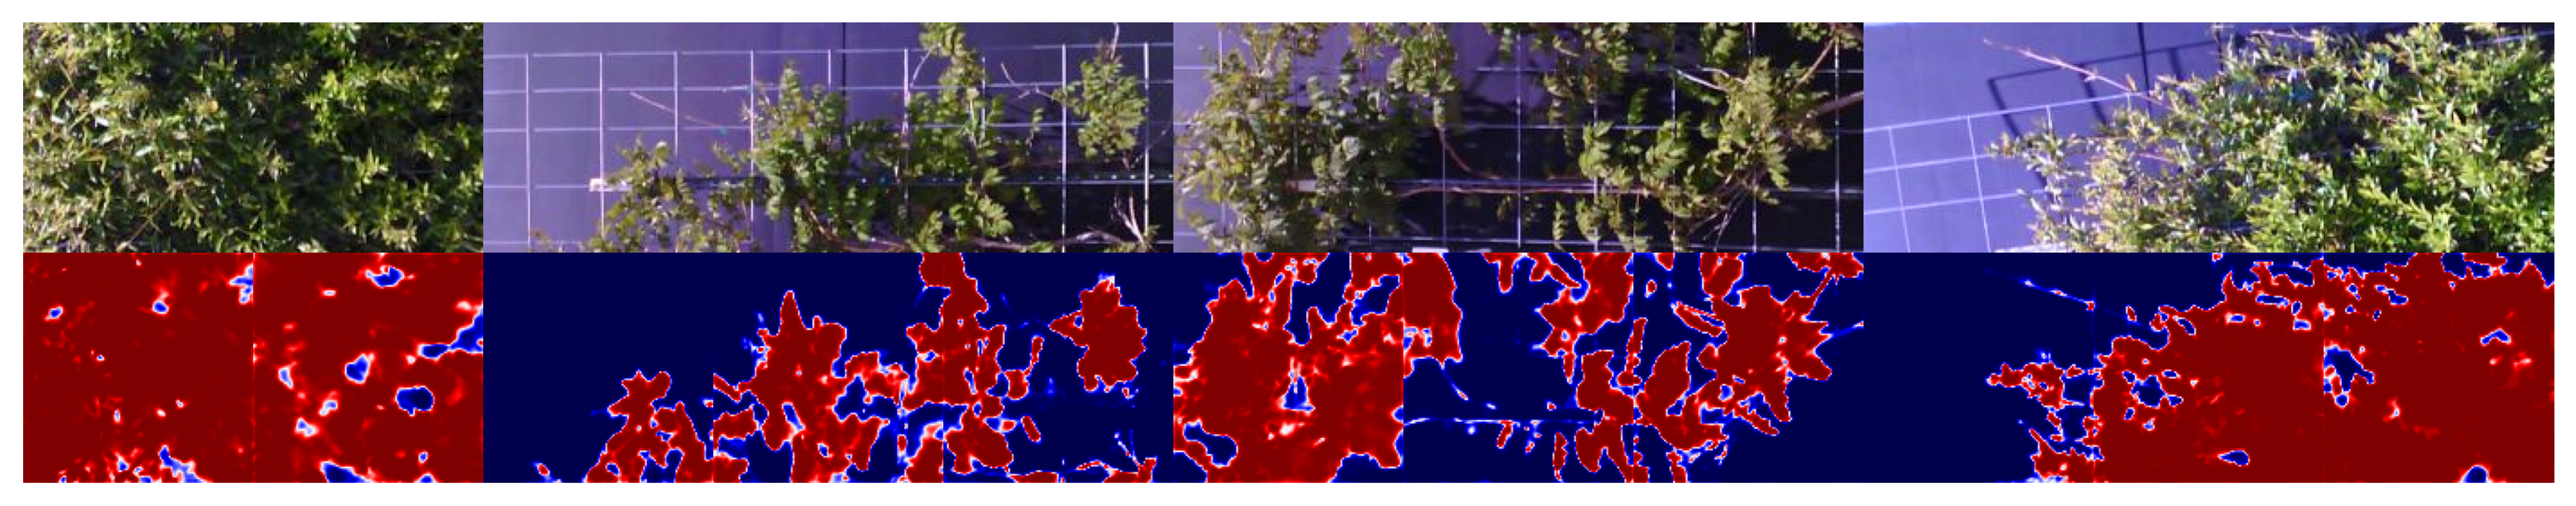

In [10]:
imnos = (list(range(len(imgstack))))
imnos = imnos[10:21]
nims = len(imnos)

(fig,axs) = plt.subplots(2, nims, figsize=(nims, nims/(nims / 2)), dpi=288)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
imgs = imgstack[imnos]
segs = segstack[imnos]

for (img, seg, axcol) in zip(imgs, segs, axs.T):
    axcol[0].imshow(img)
    axcol[1].imshow(seg, cmap='seismic', vmin=0, vmax=1)
for ax in axs.flat:
    ax.axis('off')

plt.show()

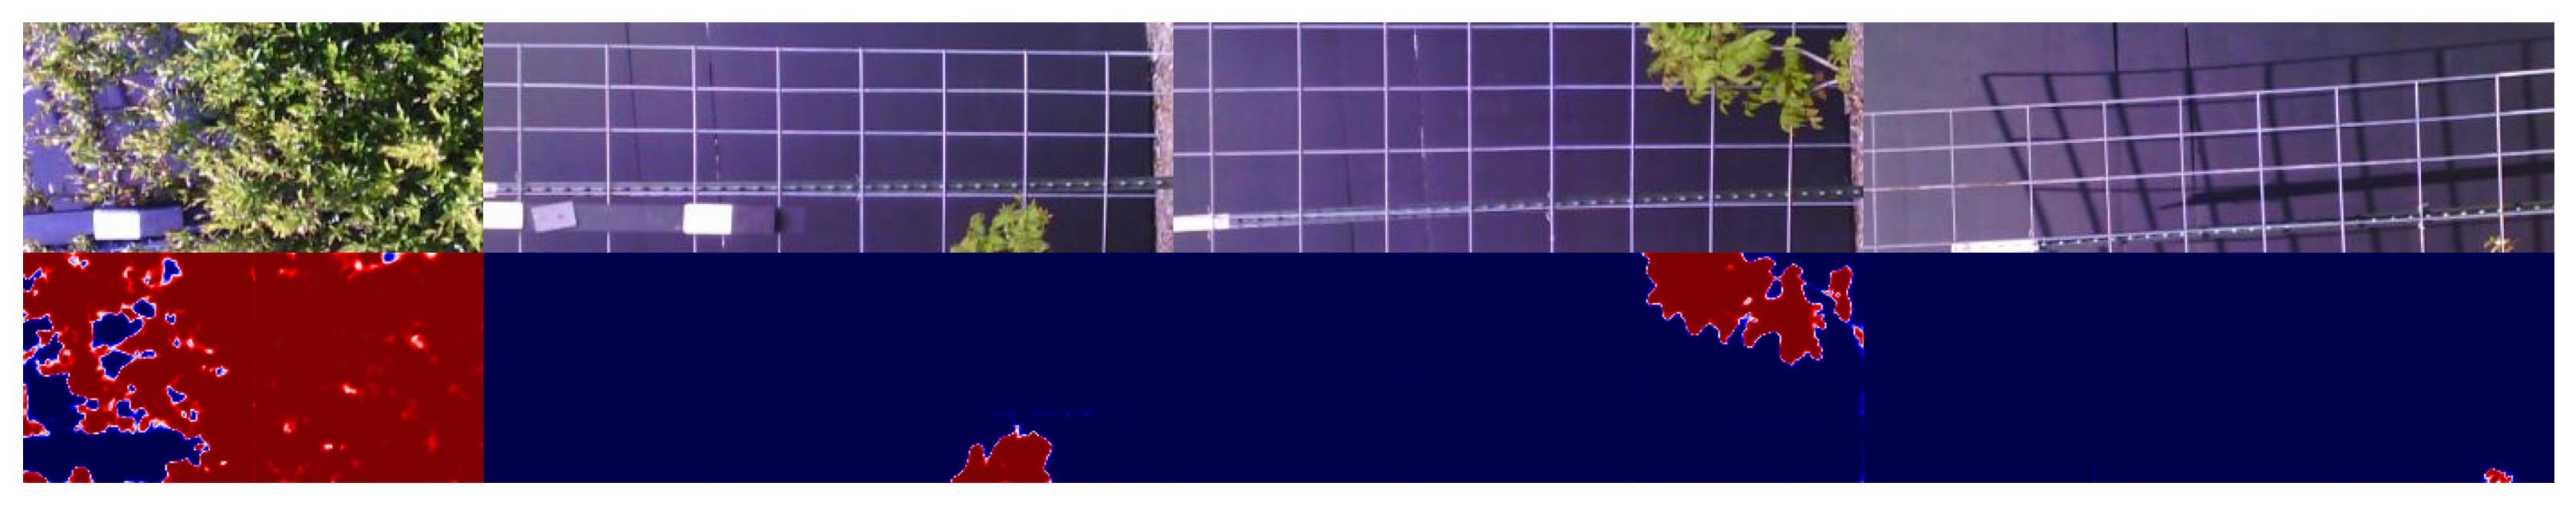

In [11]:
imnos = (list(range(len(imgstack))))
imnos = imnos[22:33]
nims = len(imnos)

(fig,axs) = plt.subplots(2, nims, figsize=(nims, nims/(nims / 2)), dpi=288)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
imgs = imgstack[imnos]
segs = segstack[imnos]

for (img, seg, axcol) in zip(imgs, segs, axs.T):
    axcol[0].imshow(img)
    axcol[1].imshow(seg, cmap='seismic', vmin=0, vmax=1)
for ax in axs.flat:
    ax.axis('off')

plt.show()

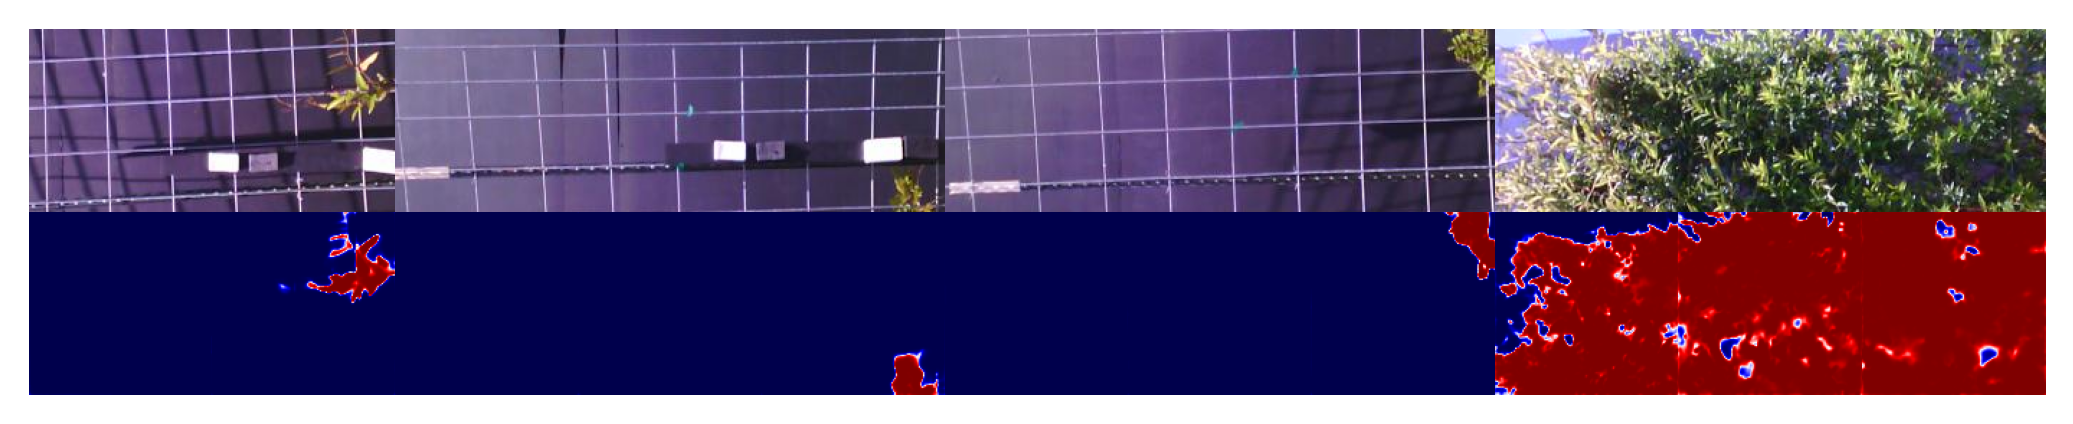

In [12]:
imnos = (list(range(len(imgstack))))
imnos = imnos[34:45]
nims = len(imnos)

(fig,axs) = plt.subplots(2, nims, figsize=(7, 7/(nims / 2)), dpi=288)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
imgs = imgstack[imnos]
segs = segstack[imnos]

for (img, seg, axcol) in zip(imgs, segs, axs.T):
    axcol[0].imshow(img)
    axcol[1].imshow(seg, cmap='seismic', vmin=0, vmax=1)
for ax in axs.flat:
    ax.axis('off')

plt.show()

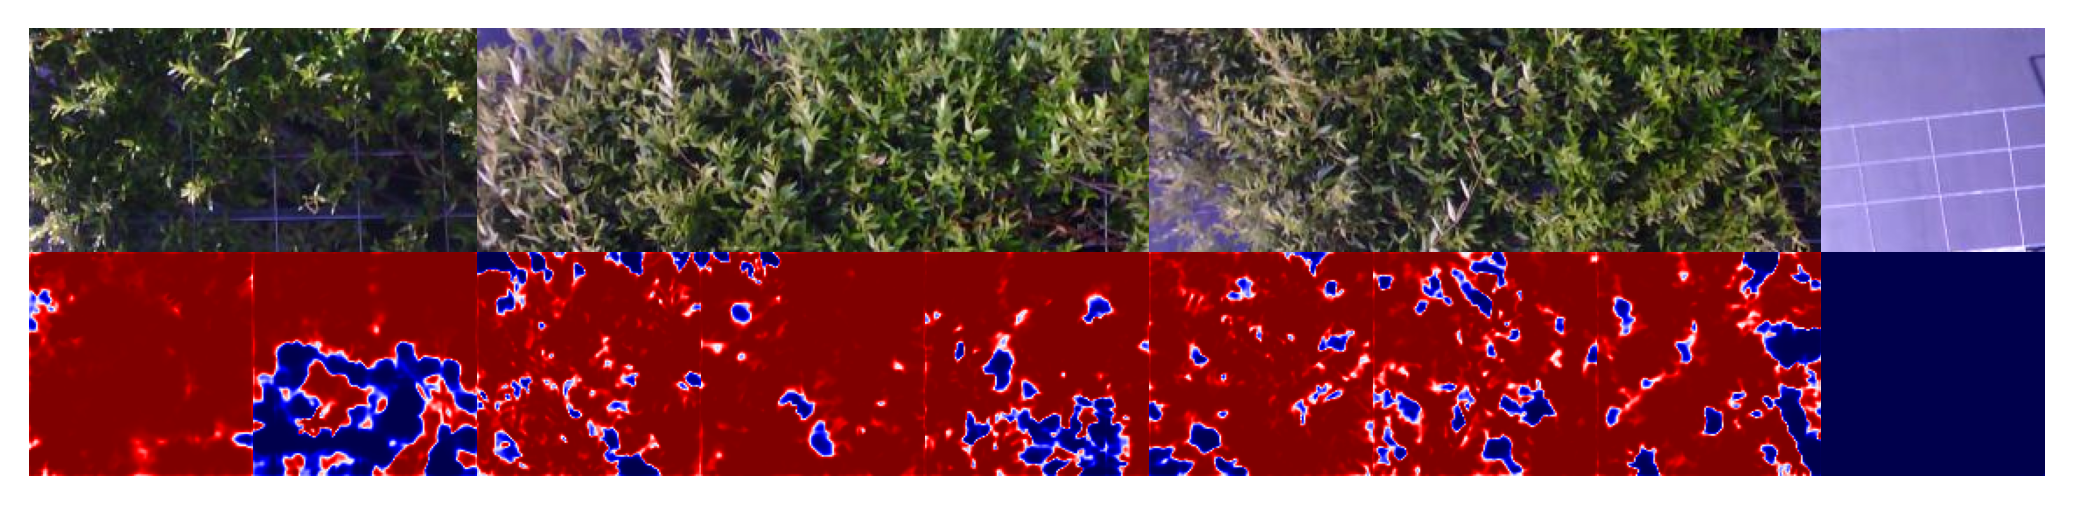

In [13]:
imnos = (list(range(len(imgstack))))
imnos = imnos[46:55]
nims = len(imnos)

(fig,axs) = plt.subplots(2, nims, figsize=(7, 7/(nims / 2)), dpi=288)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
imgs = imgstack[imnos]
segs = segstack[imnos]

for (img, seg, axcol) in zip(imgs, segs, axs.T):
    axcol[0].imshow(img)
    axcol[1].imshow(seg, cmap='seismic', vmin=0, vmax=1)
for ax in axs.flat:
    ax.axis('off')

plt.show()

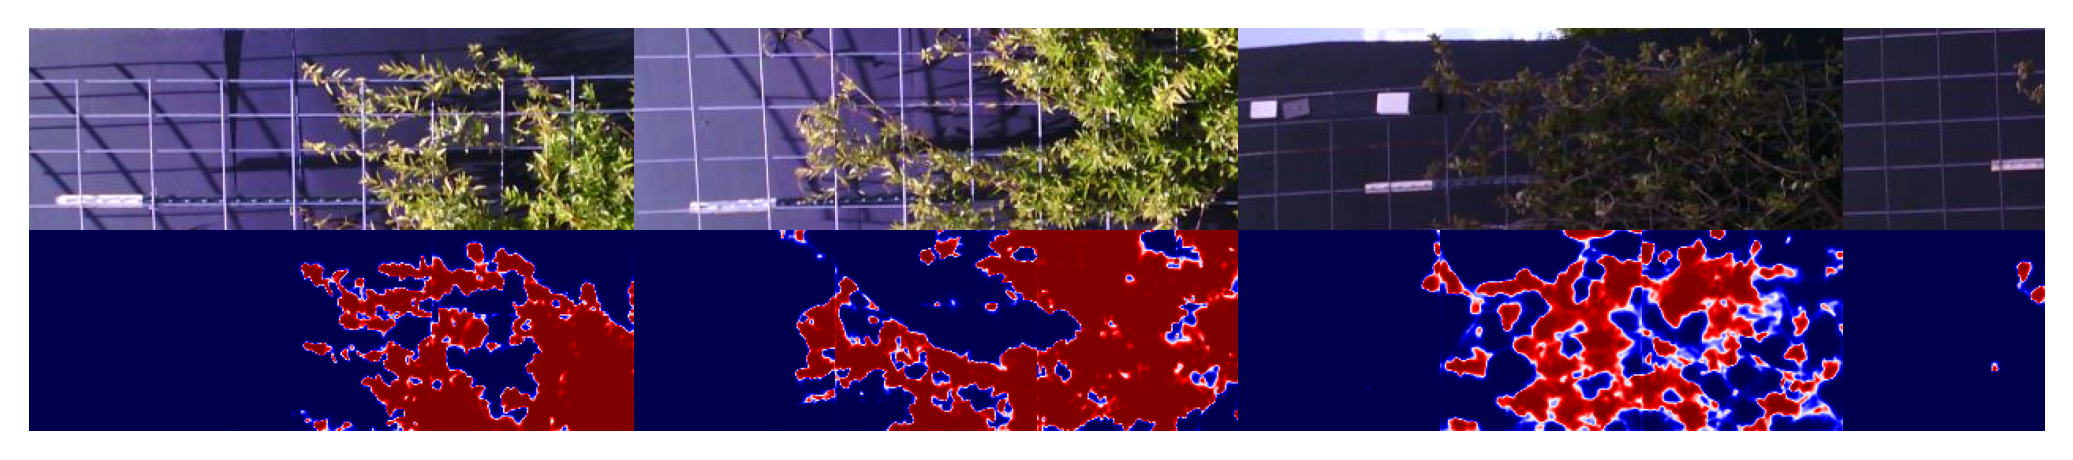

In [19]:
imnos = (list(range(len(imgstack))))
imnos = imnos[420:430]
nims = len(imnos)

(fig,axs) = plt.subplots(2, nims, figsize=(7, 7/(nims / 2)), dpi=288)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
imgs = imgstack[imnos]
segs = segstack[imnos]

for (img, seg, axcol) in zip(imgs, segs, axs.T):
    axcol[0].imshow(img)
    axcol[1].imshow(seg, cmap='seismic', vmin=0, vmax=1)
for ax in axs.flat:
    ax.axis('off')

plt.show()

In [ ]:
(imgstack, segstack, trgstack) = test_ds.pred_all(model)

In [ ]:
imnos = [1, 8, 10, 15, 40]
nims = len(imnos)

(fig,axs) = plt.subplots(3, nims, figsize=(7, 7/(nims / 3)), dpi=288)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
imgs = imgstack[imnos]
segs = segstack[imnos]
trgs = trgstack[imnos]

for (img, seg, trg, axcol) in zip(imgs, segs, trgs, axs.T):
    axcol[0].imshow(img)
    axcol[1].imshow(seg, cmap='seismic', vmin=0, vmax=1)
    axcol[2].imshow(trg, cmap='seismic', vmin=0, vmax=1)
for ax in axs.flat:
    ax.axis('off')

plt.show()

In [ ]:
# # training/testing for the resnet
# import torch
# import torchvision

# # Hyperparameters:
# n_epochs = 15  # 1 epoch == show all training data to the model once. 8 is a small number to start with
# lr = 0.0005   # We use a fairly low learning rate. take small steps as you train
# batch_size = len(train_ds)  # How many images in one training batch. 

# # Make the model:
# model = FlirResNet()

# # Make the optimizer and LR-manager:
# optimizer = torch.optim.Adam(model.parameters(), lr=lr) #optimizer handles updating the parameters each step
# steplr = torch.optim.lr_scheduler.StepLR(
#     optimizer,
#     step_size=1,
#     gamma=0.65) #take smaller steps in the learning rate as you get closer

# # Declare our loss function: what's actually getting minimized
# loss_fn = torch.nn.L1Loss() 

# # Make the dataloaders:
# train_dloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# test_dloader = torch.utils.data.DataLoader(test_ds, batch_size=len(test_ds), shuffle=True)

# # Now we start the optimization loop:
# for epoch_num in range(n_epochs):
#     # Put the model in train mode:
#     model.train()
#     # In each epoch, we go through each training sample once; the dataloader
#     # gives these to us in batches:
#     total_train_loss = 0
#     for (inputs, targets) in train_dloader:
#         # We're starting a new step, so we reset the gradients.
#         optimizer.zero_grad()
#         # Calculate the model prediction for these inputs.
#         preds = model(inputs)
#         # Calculate the loss between the prediction and the actual outputs.
#         train_loss = loss_fn(torch.sigmoid(preds), targets) #sigmoid gives the probability
#         # Have PyTorch backward-propagate the gradients.
#         train_loss.backward()
#         # Have the optimizer take a step: (update the parameters)
#         optimizer.step()
#         # Add up the total training loss:
#         total_train_loss = total_train_loss + train_loss*len(targets)
#     # LR Scheduler step:
#     steplr.step() #make the learning rate smaller
#     mean_train_loss = total_train_loss.detach() / len(train_ds)
#     # Now that we've finished training, put the model back in evaluation mode.
#     model.eval()
#     ## Evaluate the model using the test data.
#     total_test_loss = 0
#     for (inputs, targets) in test_dloader:
#         preds = model(inputs)
#         test_loss = loss_fn(preds, targets)
#         total_test_loss = total_test_loss + test_loss # changed from train loss
#     mean_test_loss = total_test_loss.detach() / len(test_ds)
#     # Print something about this step:
#     print(f"Epoch {epoch_num:2d} loss: {mean_train_loss:6.3f}")
# # After the optimizer has run, print out what it's found:
# print("Final result:")
# print(f"  train loss = ", float(mean_train_loss))
# print(f"   test loss = ", float(mean_test_loss))

In [ ]:
model.eval()
## Evaluate the model using the test data.
total_test_loss = 0
for (inputs, targets) in test_dloader:
    preds = model(inputs)
    test_loss = dice_loss(preds, targets, logits=True)
    total_test_loss = total_test_loss + test_loss*len(targets) # changed from train loss
mean_test_loss = total_test_loss.detach() / len(test_ds)
# After the optimizer has run, print out what it's found:
print("Final result:")
print(f"  train loss = ", float(mean_train_loss))
print(f"   test loss = ", float(mean_test_loss))

In [ ]:
# extracting temperatures
# given this segmentation, what temp are the 

In [ ]:
# plotting predictions

In [ ]:
# if the test loss is greated than the train loss = overfit
# can run the model on any of the test images from the test dataset - try running the model with a bunch of image patches and see if you think it's running sensible results

In [ ]:
# plt.imshow(
#     mpl.image.imread('/Users/nben/Desktop/monthly images/6_25/RGB/FLIR2369.jpg'))

In [ ]:
plt.imshow(th0)

In [ ]:
plt.imshow(im0)

In [ ]:
plt.imshow(
    np.stack(
        [pcv.hist_equalization(im0[:,:,k])
         for k in (0,1,2)],
        axis=2))

In [ ]:
?pcv.threshold.binary

In [ ]:
plt.imshow(im)

In [ ]:
b_img = pcv.rgb2gray_lab(rgb_img=im, channel='b')

In [ ]:
plt.imshow(b_img, vmin=0, vmax=255)

In [ ]:
thresh_mask = pcv.threshold.binary(gray_img=b_img, threshold=120, object_type='light')

In [ ]:
plt.imshow(thresh_mask, cmap='gray')

In [ ]:
immask = np.array(im)
immask[thresh_mask > 0, :] = 0
plt.imshow(immask)

In [ ]:
hist_figure1, hist_data1 = pcv.visualize.histogram(img = b_img, hist_data=True)

In [ ]:
hist_figure1

In [ ]:
im = mpl.image.imread('/Users/nben/Desktop/FLIR3099.png')

In [ ]:
plt.imshow(im)